In [1]:
import rootutils
rootutils.setup_root(".", indicator=".project-root", pythonpath=True, cwd=True)

PosixPath('/home/dgcnz/development/thesis/PART')

In [2]:
cwd = rootutils.find_root()
print(type(cwd))

<class 'pathlib.PosixPath'>


In [3]:
import pytest
from PIL import Image
import torchvision.transforms.v2.functional as TTFv2
import hydra
from omegaconf import OmegaConf
import torch
from src.models.part_vit_module import PARTViTModule
from src.data.hf_datamodule import HFDataModule
import lightning as L
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from copy import deepcopy
# import plotly dash
import dash


In [4]:
def get_img():
    img = Image.open("artifacts/img.jpg")
    img = img.resize((224, 224))
    patch_size = 16
    num_patches = (224 // patch_size) ** 2
    return img, patch_size, num_patches


def get_cfg():
    with hydra.initialize(version_base=None, config_path="../../configs"):
        cfg = hydra.compose(
            config_name="train.yaml",
            overrides=[
                "experiment=hs_part_im1k_pairdiff_mlp",
                "model/criterion_fn=l1",
                "model.sample_mode=offgrid",
                "data.num_workers=0",
            ],
        )
    OmegaConf.register_new_resolver("eval", eval)
    return cfg


def get_train_transform():
    with hydra.initialize(version_base=None, config_path="../../configs"):
        cfg = hydra.compose(
            config_name="train.yaml",
            overrides=[
                "experiment=hs_part_im1k_pairdiff_mlp",
                "model/criterion_fn=l1",
                "model.sample_mode=offgrid",
                "data.num_workers=0",
            ],
        )

    transform = hydra.utils.instantiate(cfg.data.train_transform)
    return transform

In [5]:
cfg = get_cfg()   

In [6]:
module: PARTViTModule = hydra.utils.instantiate(cfg.model)
datamodule: HFDataModule = hydra.utils.instantiate(cfg.data)
datamodule.setup("fit")
train_dataloader = datamodule.train_dataloader()
train_iter = iter(train_dataloader)
batch = next(train_iter)


/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'train_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['train_transform'])`.
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'test_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['test_transform'])`.


Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

tensor(0.3076)
Normal Loss: 0.3484
tensor(0.3076)
Uniform Loss: 0.3363
tensor(0.3076)
Default Loss: 0.4962


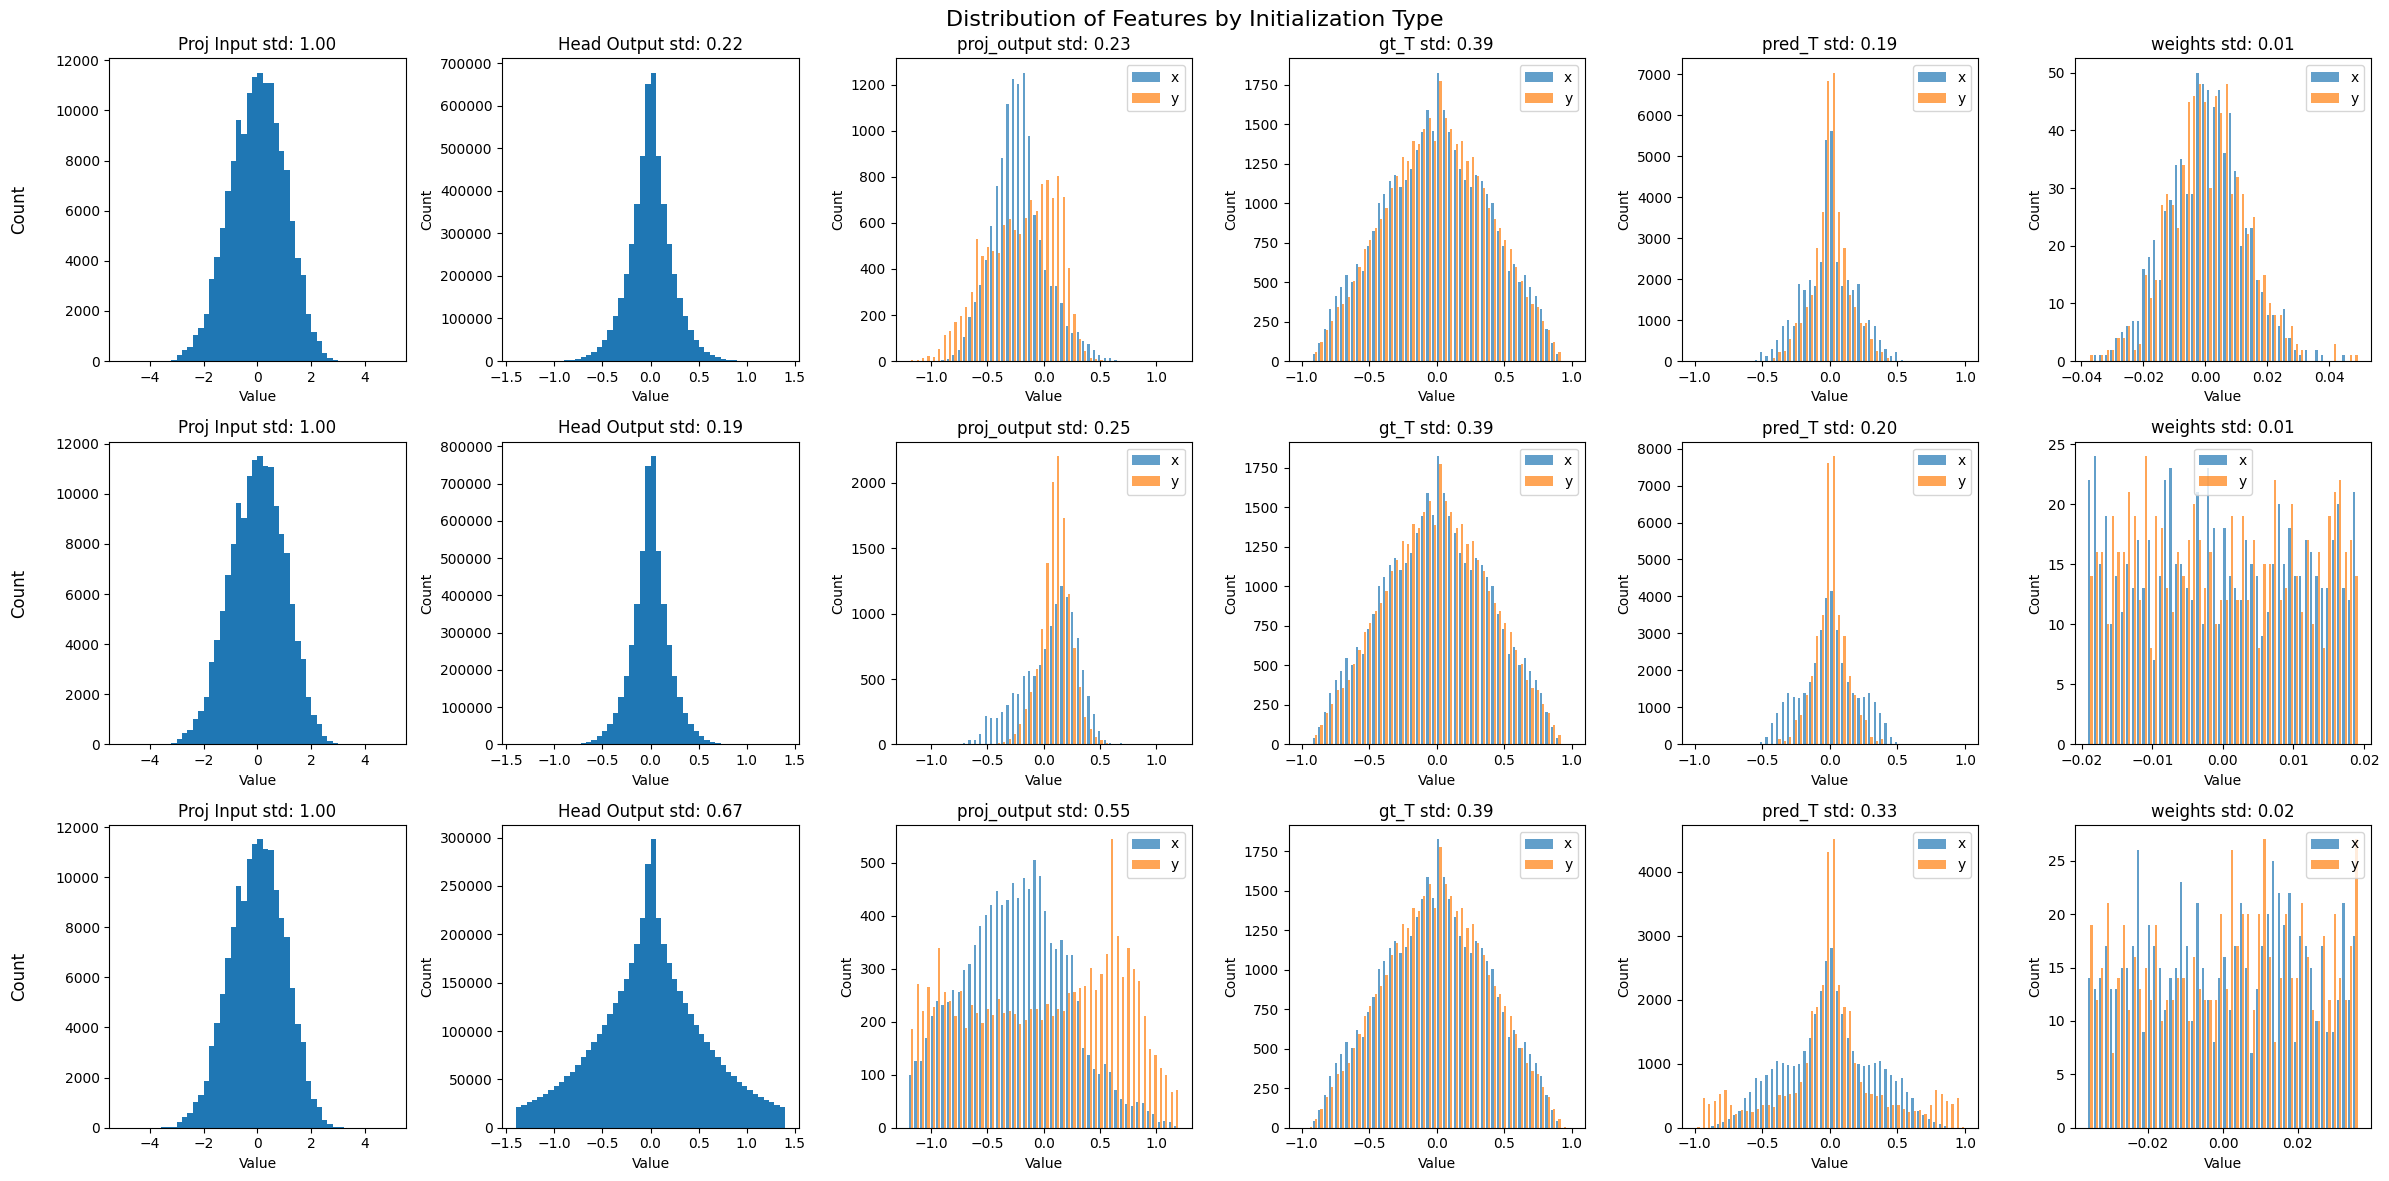

In [12]:
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib 
# jupyter matplotlib
%matplotlib inline

# Function to run experiment and plot results
# Store input features
def run_and_plot(init_type, module, fig, axes):

    proj_input_features = []
    proj_output_features = []
    backbone_features = []
    head_input_features = []
    head_output_features = []

    def hook_fn(module, input, output):
        proj_input_features.append(input[0].detach().cpu())
        proj_output_features.append(output.detach().cpu())

    def head_hook_fn(module, input, output):
        head_input_features.append(input[0].detach().cpu())
        head_output_features.append(output.detach().cpu())

    def backbone_hook_fn(module, input, output):
        backbone_features.append(output.detach().cpu())



    # Clear stored features
    proj_input_features.clear()
    proj_output_features.clear()
    backbone_features.clear()
    
    # Register hooks
    head_hook = module.net.head.register_forward_hook(head_hook_fn)
    proj_hook = module.net.head.proj.register_forward_hook(hook_fn)
    backbone_hook = module.net.backbone.register_forward_hook(backbone_hook_fn)

    import math
    torch.manual_seed(0)
    if init_type == "normal":
        fan_in = module.net.head.proj.weight.shape[1]
        # std = 1.0 / (5.0 * math.sqrt(fan_in))
        std = 1.0 / (3 * math.sqrt(fan_in))
        # std = 1.5 / (5.0 * math.sqrt(fan_in))
        module.net.head.proj.weight.data.normal_(0, std)
        # torch.nn.init.kaiming_normal_(module.net.head.proj.weight, mode='fan_out', nonlinearity='tanh')
    elif init_type == "uniform":
        fan_in = module.net.head.proj.weight.shape[1]
        # bound = 1.0/(5.0 * math.sqrt(3.0 * fan_in))
        # bound = math.sqrt(3.0/(25.0 * fan_in))  
        # bound = 1.0/(3 * math.sqrt(fan_in))
        # bound = math.sqrt(5.0/(25.0 * fan_in))  
        # module.net.head.proj.weight.data.uniform_(-bound, bound)
        torch.nn.init.kaiming_uniform_(module.net.head.proj.weight, a=4.5)

        # module.net.proj.weight.data.fill_(0)
    else: # default
        # module.net.head.proj.reset_parameters()
        pass

    # record memory history torch
    # torch seed
    torch.manual_seed(0)
    with torch.no_grad(): 
        module.eval()
        out = module.model_step(batch)
    
    # Remove hooks
    head_hook.remove()
    proj_hook.remove()
    backbone_hook.remove()

    # Separate x and y components for selected tensors
    gt_T_y, gt_T_x = module.norm_T(out["gt_T"].detach().cpu())[0].unbind(dim=-1)
    pred_T_y, pred_T_x = module.norm_T(out["pred_T"].detach().cpu())[0].unbind(dim=-1)
    weights_y, weights_x = module.net.head.proj.weight.detach().cpu()
    proj_out_y, proj_out_x = proj_output_features[0].unbind(dim=-1)

    # Define the data mapping
    data = {
        'proj_output': (proj_out_x, proj_out_y, -1.2, 1.2),
        'gt_T': (gt_T_x, gt_T_y, -1, 1),
        'pred_T': (pred_T_x, pred_T_y, -1, 1),
        'weights': (weights_x, weights_y, None, None),
    }
    # compute expected loss under l1 regression
    gt_T = module.norm_T(out["gt_T"]).detach().cpu()
    median = gt_T.median().item()
    median_T = torch.full_like(gt_T, median)
    loss = torch.nn.functional.l1_loss(gt_T, median_T)
    print(loss)
    


    # Map initialization type to row index
    row_idx = {'normal': 0, 'uniform': 1, 'default': 2}[init_type]

    # plot proj_input first
    proj_input = proj_input_features[0][0]
    axes[row_idx, 0].hist(proj_input.flatten(), bins=50, range=(-5, 5))
    axes[row_idx, 0].set_xlabel('Value')
    axes[row_idx, 0].set_ylabel('Count')
    std = torch.std(proj_input)
    axes[row_idx, 0].set_title(f"Proj Input std: {std:.2f}")

    # head_input = head_input_features[0][0]
    # axes[row_idx, 1].hist(head_input.flatten(), bins=50, range=(-5, 5))
    # axes[row_idx, 1].set_xlabel(' Value')
    # axes[row_idx, 1].set_ylabel('Count')
    # std = torch.std(head_input)
    # axes[row_idx, 1].set_title(f"Head Input std: {std:.2f}")

    # do this for head_output
    head_output = head_output_features[0]
    axes[row_idx, 1].hist(head_output.flatten(), bins=50, range=(-1.4, 1.4))
    axes[row_idx, 1].set_xlabel('Value')
    axes[row_idx, 1].set_ylabel('Count')
    std = torch.std(head_output)
    axes[row_idx, 1].set_title(f"Head Output std: {std:.2f}")



    # Plot the rest of the data
    for col, (name, (x_data, y_data, mn, mx)) in enumerate(data.items(), start=2):
        axes[row_idx, col].hist([x_data.flatten(), y_data.flatten()], bins=50, 
                               label=['x', 'y'], alpha=0.7, range=(mn, mx) if mn is not None else None)
        axes[row_idx, col].legend()
        axes[row_idx, col].set_xlabel('Value')
        axes[row_idx, col].set_ylabel('Count')
        # plot in legend
        std = torch.std(x_data)

        axes[row_idx, col].set_title(f"{name} std: {std:.2f}")



    return out["loss"]

# Create figure and axes
fig, axes = plt.subplots(3, 6, figsize=(24, 12))

# Add a main title
fig.suptitle('Distribution of Features by Initialization Type', fontsize=16)

# Add column labels
col_labels = ['features', 'proj_input', 'proj_output', 'gt_T', 'pred_T', 'weights']
for ax, col in zip(axes[0], col_labels):
    ax.set_title(col, fontsize=12, pad=20)

# Add row labels
row_labels = ['Normal', 'Uniform', 'Default']
for ax, row in zip(axes[:, 0], row_labels):
    ax.set_ylabel(row, fontsize=12, rotation=90, labelpad=20)

# Run the experiment and plot results for each initialization type
init_types = ['normal', 'uniform', 'default']
for init_type in init_types:
    module_copy = deepcopy(module)
    loss = run_and_plot(init_type, module_copy, fig, axes)
    print(f"{init_type.capitalize()} Loss: {loss:.4f}")

plt.tight_layout()
plt.show()


Unit Std: 1.0000
Std 1: 0.5000
Unit Std Var: 1.0000
Std 1 Var: 0.2500


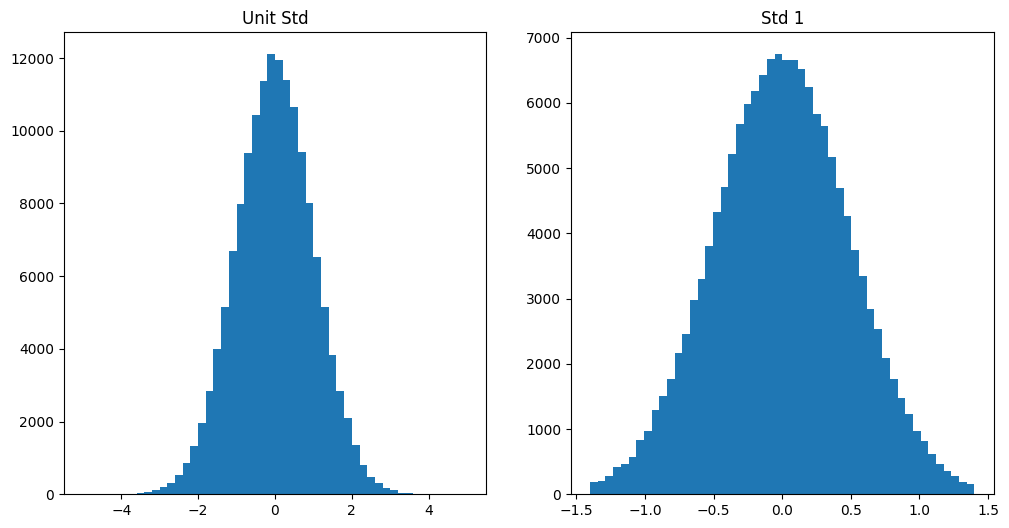

In [8]:
# data = torch.randn(1, 3, 224, 224)
# make data with std=1, plot
unit_std = torch.randn(1, 3, 224, 224)
unit_std /= torch.std(unit_std)

# make data that yields 99.7% of data in [-1, 1]
std_1 = torch.randn(1, 3, 224, 224)
std_1 /= 2 * torch.std(std_1)

print(f"Unit Std: {torch.std(unit_std):.4f}")
print(f"Std 1: {torch.std(std_1):.4f}")


var_unit = torch.var(unit_std)
var_std_1 = torch.var(std_1)



print(f"Unit Std Var: {var_unit:.4f}")
print(f"Std 1 Var: {var_std_1:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(unit_std.flatten(), bins=50, range=(-5, 5))
axes[0].set_title("Unit Std")
axes[1].hist(std_1.flatten(), bins=50, range=(-1.4, 1.4))
axes[1].set_title("Std 1")
plt.show()
